In [1]:
projectdir = "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia"
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, Interact, LsqFit, CSV, Blink, Pipe, ProgressMeter
pyplot()

include("Turnover.jl")
include("test.jl")
using .Turnover

import TumorGrowth
include(projectdir*"/distribution_functions.jl")
include(projectdir*"/simulated_tumors/path_format.jl")
plot(size=(1,1))

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17902505150064936614\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-2603481928450022220\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17902505150064936614\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`

Test Summary:             | Pass  Total
Applying turnover methods |    7      7


In [2]:
# mes2theory_orphaned(t_mes, p = [0.188, 17.688]) = @. p[1]*( 1/(1+exp(-p[2]*t_mes)) -1/2 )
mes2theory_orphaned(t_mes) = t_mes * 2

# mes2theory_estranged(t_mes, p = [0.603, 1.267]) = map(t_mes) do t
mes2theory_estranged(t_mes, p = [0.391, 0.783]) = map(t_mes) do t
    if p[1]/p[2] > 1/2 
        10
    else
        t >= p[1] ? 1. : log( 1/ ( t*1/p[2] + 1/2 ) - 1 ) / log( 1/ ( p[1]/p[2] + 1/2 ) - 1)
    end
end

mes2theory_estranged (generic function with 2 methods)

In [3]:
using TumorGrowth: multi_region_sequencing, haplotypes, data_import
import TumorGrowth
include(projectdir*"/simulated_tumors/path_format.jl")

In [4]:
tumorinfo = dir_info(projectdir*"/simulated_tumors/2d/bulk")
first(filter(row -> row.N==40000, tumorinfo), 6)

,N,b,d,μ,ρ,dim,id,path
,Int64,Float64,Float64,Float64,Float64,Int64,Int64,String
1,40000,1.0,0.4,0.2,Inf,2,8830,C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/simulated_tumors/2d/bulk\\tumor_N40000_b1.0_d0.4_μ0.2_ρInf_2d_id8830.csv


### Single cells

In [109]:
drange = 0:0.1:0.9
ds = Float64[]
mus = Float64[]
Worph = Float64[]
Westr = Float64[]
res = 1/1000
Nthresh = 200

prog = Progress(length(drange))
for d in drange
    paths = filter(row -> row.d == d, tumorinfo).path
    for path in paths
        parameters = read_params(path)
        b, mu = parameters.b, parameters.μ
        Nthresh = 200
        
        tumor = data_import(path)
        
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        htypes = filter.(m -> freqs[m] > res, unique(tumor.mutations))
        
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)
        
        
        Ls = 0.1:0.1:1.
        reps = 5
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                    end )
            end
        
        for (i,w_estr_set) in enumerate(estranged_turnover)
            for w_estr in w_estr_set
                push!(ds, d)
                push!(Worph, W_l)
                push!(mus, round(Ls[i]*mu, digits=3))
                push!(Westr, w_estr)
            end
        end
             
    end
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:14:12


In [110]:
turnover_data = DataFrame(d=ds, orphaned = Worph, mu = mus, estranged = Westr);

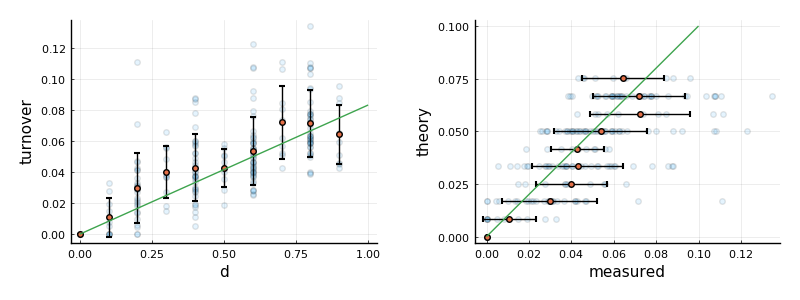

In [98]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    scatter!(p[1],res.d, res.orphaned, alpha=0.1, xlab=:d, ylab=:turnover)
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.orphaned), groups),
        yerror = map(set -> std(set.orphaned), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> W_orphaned(d; N=400))
    
    scatter!(p[2], res.orphaned, W_orphaned.(res.d; N=400), alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.orphaned), groups),
        xerror = map(set -> std(set.orphaned), groups),
        W_orphaned.(ds_unique; N=400), ms=4. )
    plot!(p[2], 0:0.01:0.1, x->x)
end

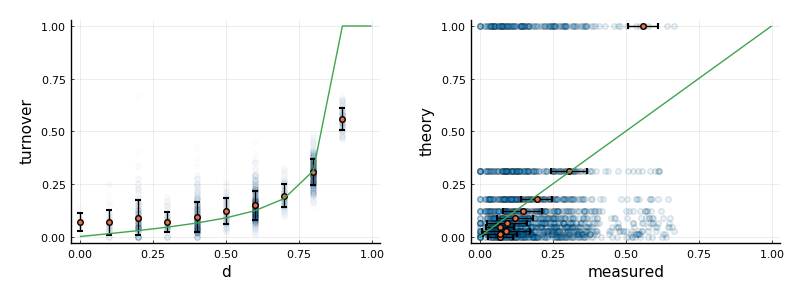

In [101]:
let mu = 0.1
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(400)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.01, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(400)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    plot!(p[2], 0:0.1:1, x->x)
end

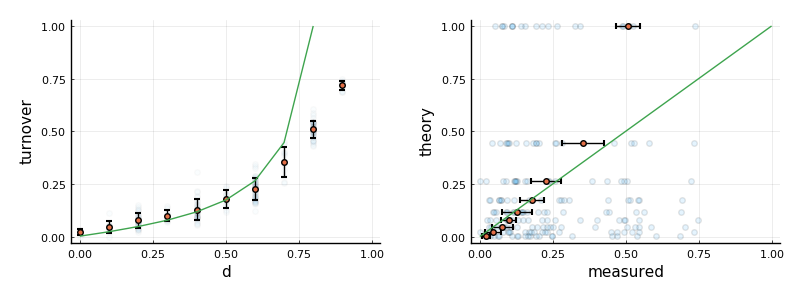

In [100]:
let mu = 0.2
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(400)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.02, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(400)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    plot!(p[2], 0:0.1:1, x->x)
end

> n 200, N 400

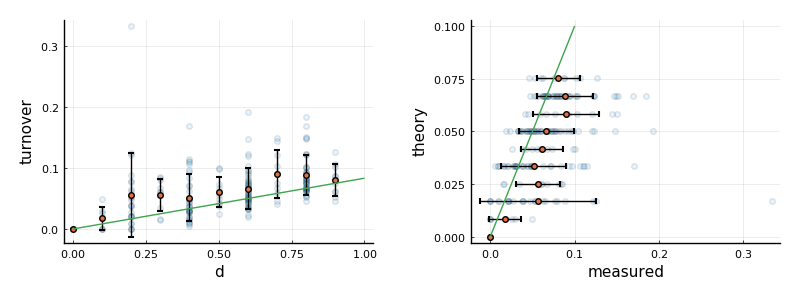

In [111]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    scatter!(p[1],res.d, res.orphaned, alpha=0.1, xlab=:d, ylab=:turnover)
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.orphaned), groups),
        yerror = map(set -> std(set.orphaned), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> W_orphaned(d; N=400))
    
    scatter!(p[2], res.orphaned, W_orphaned.(res.d; N=400), alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.orphaned), groups),
        xerror = map(set -> std(set.orphaned), groups),
        W_orphaned.(ds_unique; N=400), ms=4. )
    plot!(p[2], 0:0.01:0.1, x->x)
end

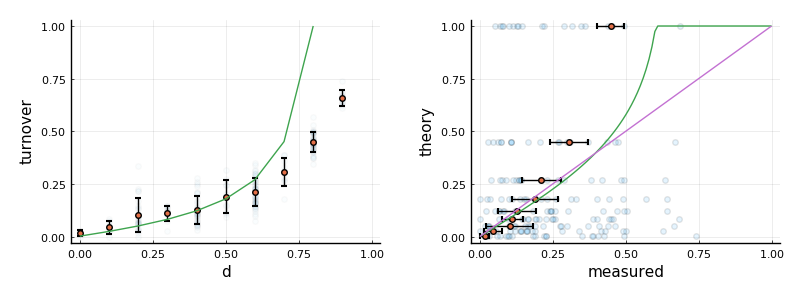

In [113]:
let mu = 0.2
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.02, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    
    plot!(p[2], 0:0.01:1, mes2theory_estranged)
    plot!(p[2], 0:0.1:1, x->x)
end

> n 200, N 200

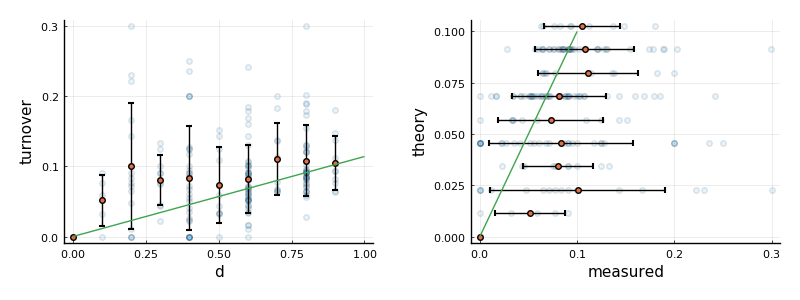

In [75]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    scatter!(p[1],res.d, res.orphaned, alpha=0.1, xlab=:d, ylab=:turnover)
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.orphaned), groups),
        yerror = map(set -> std(set.orphaned), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> W_orphaned(d; N=Nthresh))
    
    scatter!(p[2], res.orphaned, W_orphaned.(res.d; N=Nthresh), alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.orphaned), groups),
        xerror = map(set -> std(set.orphaned), groups),
        W_orphaned.(ds_unique; N=Nthresh), ms=4. )
    plot!(p[2], 0:0.01:0.1, x->x)
end

In [95]:
# CSV.write("turnover_data/singlecell_N80_res600.csv", turnover_data)
turnover_data = CSV.read("turnover_data/singlecell_N80_res600.csv", DataFrame);

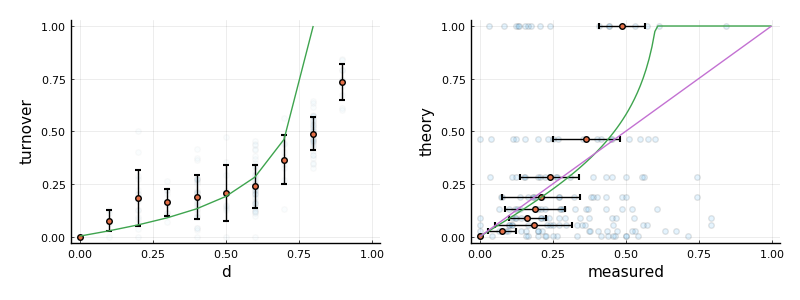

In [78]:
let mu = 0.2
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.02, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    
    plot!(p[2], 0:0.01:1, mes2theory_estranged)
    plot!(p[2], 0:0.1:1, x->x)
end

> n 200, N 80

In [5]:
using LsqFit
model(t_mes, p) = map(t_mes) do t
    try
        t >= p[1] ? 1. : log( 1/ ( t*1/p[2] + 1/2 ) - 1 ) / log( 1/ ( p[1]/p[2] + 1/2 ) - 1)
        catch e
        10
    end
end

model (generic function with 1 method)

In [115]:
res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    
groups = collect(groupby(res, :d, sort=true))
ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=0.2, T=log(Nthresh)/(1. -d))), ds_unique)

t_theo, t_mes = [ min( 1, abs( Turnover.W_estranged(d; b=1, μ=0.2, T=log(Nthresh)/(1. -d)) ) ) for d in ds_unique], map(set -> mean(set.estranged), groups)
fitres = curve_fit( model, t_mes, t_theo, [0.7, 2])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.337888865204702, 0.6776286699947051], [0.01325524284285735, 0.01559531236305857, 0.04487871805047362, 0.021030956720098443, -0.001493517994351462, 0.012099597477980145, -0.04854555087503007, 0.002978257062249745, 0.0, 0.0], [-2.519263593300039 1.2334851519791477; -6.583792537753418 3.2229728607260757; … ; 0.0 0.0; 0.0 0.0], true, Float64[])

In [116]:
fitres.param

2-element Vector{Float64}:
 0.337888865204702
 0.6776286699947051

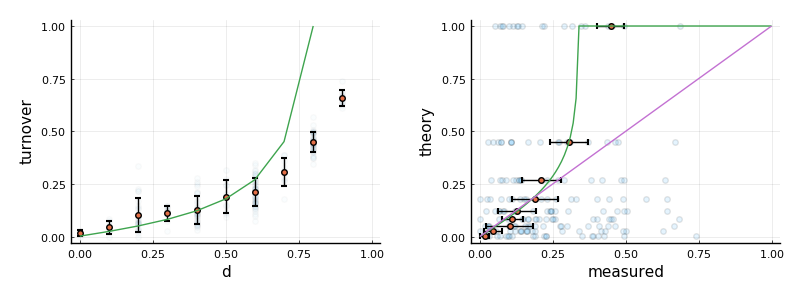

In [117]:
let mu = 0.2
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.02, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    
    plot!(p[2], 0:0.01:1, t-> model(t, fitres.param))
    plot!(p[2], 0:0.1:1, x->x)
end

## Sampled

In [28]:
drange = 0:0.1:0.9
ds = Float64[]
mus = Float64[]
Worph = Float64[]
Westr = Float64[]

Nthresh_orph = 200
Nthresh_estr = 200
res = 1/10000

let mu = 0.2
    paths = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in drange, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, d = parameters.b, parameters.d
        
        tumor = data_import(path)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        
#         samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=285)
#         for row in eachrow(sampletumor)
#             row.mutations = row.mutations[row.frequencies .>= 1/3]
#         end

#         htypes = unique!( filter!.(m-> freqs[m] > res , sampletumor.mutations) )
        
        htypes = filter.(m-> freqs[m] > res, sample(tumor.mutations, 285, replace=false))
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), htypes) )
        
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)
        
        W_o = estranged_treeless(estranged_tumor) |>
                df -> sum(df.isestranged)/sum(df.isgreen)
    
        push!(ds, d)
        push!(Worph, W_l)
        push!(mus, mu)
        push!(Westr, W_o)
        
        next!(prog)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:11:19


In [29]:
turnover_data = DataFrame(d=ds, mu = mus, 
    estranged = replace(Westr, NaN=>missing), orphaned = replace(Worph, NaN=>missing),
) |> dropmissing!
nrow(turnover_data)

208

y = -0.143 + 1.714 x


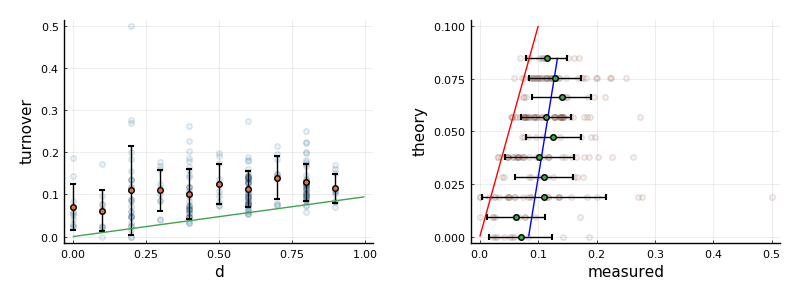

In [30]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    scatter!(p[1],res.d, res.orphaned, alpha=0.1, xlab=:d, ylab=:turnover)
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.orphaned), groups),
        yerror = map(set -> std(set.orphaned), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> W_orphaned(d; N=Nthresh_orph))
    
    y,x = W_orphaned.(res.d; N=Nthresh_orph), res.orphaned
    w = hcat(ones(length(y)), y)    
    
    beta = (w'*w) \ (w'*x)
    println("y = ",round(-beta[1]/beta[2],digits=3), " + ", round(1/beta[2],digits=3), " x")
    plot!(p[2], w*beta, y, c=:blue)
    scatter!(p[2], res.orphaned, W_orphaned.(res.d; N=Nthresh_orph), alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.orphaned), groups),
        xerror = map(set -> std(set.orphaned), groups),
        W_orphaned.(ds_unique; N=Nthresh_orph), ms=4. )
    plot!(p[2], 0:0.01:0.1, x->x, c=:red)
end

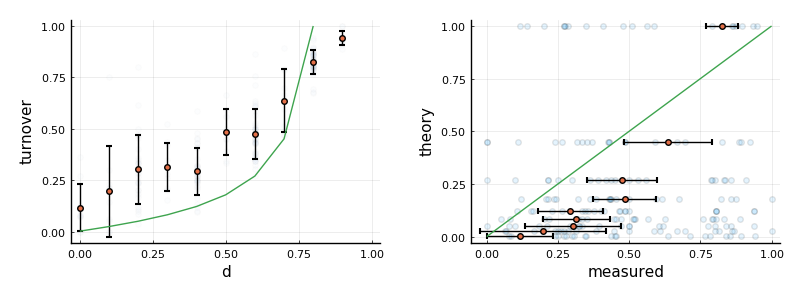

In [31]:
let mu = 0.2
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh_estr)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.01, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh_estr)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    plot!(p[2], 0:0.01:1, x->x)
end

[0.6526237988856363, 1.3054199661551076]


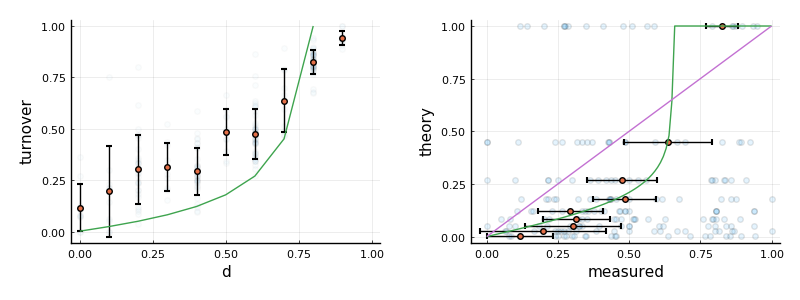

In [32]:
res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    
groups = collect(groupby(res, :d, sort=true))
ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=0.2, T=log(Nthresh_estr)/(1. -d))), ds_unique)

t_theo, t_mes = [ min( 1, abs( Turnover.W_estranged(d; b=1, μ=0.2, T=log(Nthresh_estr)/(1. -d)) ) ) for d in ds_unique], map(set -> mean(set.estranged), groups)
fitres = curve_fit( model, t_mes, t_theo, [0.7, 2])

println(fitres.param)

let mu = 0.2
    res = filter(row-> row.mu ≈ mu, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none)
    
    groups = collect(groupby(res, :d, sort=true))
    ds_unique = getproperty.(keys(groupby(res, :d, sort=true)), :d)
    estr_theo = map( d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh_estr)/(1. -d))), ds_unique)
    
    scatter!(p[1],res.d, res.estranged, alpha=0.02, xlab=:d, ylab=:turnover)
    scatter!(p[1],  ds_unique,
        map(set -> mean(set.estranged), groups),
        yerror = map(set -> std(set.estranged), groups), ms=4. )
    plot!(p[1], 0:0.1:1, d -> min(1., W_estranged(d; b=1, μ=mu, T=log(Nthresh_estr)/(1. -d))) )
    
    scatter!(p[2], res.estranged, estr_theo, alpha=0.1, xlab=:measured, ylab=:theory)
    scatter!(p[2], map(set -> mean(set.estranged), groups),
        xerror = map(set -> std(set.estranged), groups),
        estr_theo, ms=4. )
    
    plot!(p[2], 0:0.01:1, t-> model(t, fitres.param))
    plot!(p[2], 0:0.1:1, x->x)
end

In [99]:
drange = 0:0.1:0.9
ds = Float64[]
mus = Float64[]
Worph_sc = Float64[]
Westr_sc = Float64[]
Worph_sa = Float64[]
Westr_sa = Float64[]

res = 1/1000
Nthresh = 80

let mu = 0.2
    paths = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in drange, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, d = parameters.b, parameters.d
        
        tumor = data_import(path)
        
        push!(mus, mu)
        push!(ds, d)
        
        #### single cell
        
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

        htypes = unique!( filter!.(m-> freqs[m] > res , tumor.mutations) )
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen)
        
        W_o = estranged_treeless(estranged_tumor) |>
            df -> sum(df.isestranged)/sum(df.isgreen)
        
        push!(Worph_sc, W_l)
        push!(Westr_sc, W_o)
        
        #### sampling
        
        samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=200)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        for row in eachrow(sampletumor)
            row.mutations = row.mutations[row.frequencies .>= 1/4]
        end

        htypes = unique!( filter!.(m-> freqs[m] > res , sampletumor.mutations) )
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)
        
        W_o = estranged_treeless(estranged_tumor) |>
                df -> sum(df.isestranged)/sum(df.isgreen)
    
        
        push!(Worph_sa, W_l)
        push!(Westr_sa, W_o)
        
        next!(prog)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:12:02


In [100]:
turnover_data = DataFrame(d=ds, mu = mus, 
    estranged_sc = replace(Westr_sc, NaN=>missing), 
    orphaned_sc = replace(Worph_sc, NaN=>missing),
    estranged_sa = replace(Westr_sa, NaN=>missing), 
    orphaned_sa = replace(Worph_sa, NaN=>missing)
) |> dropmissing!
nrow(turnover_data)

207

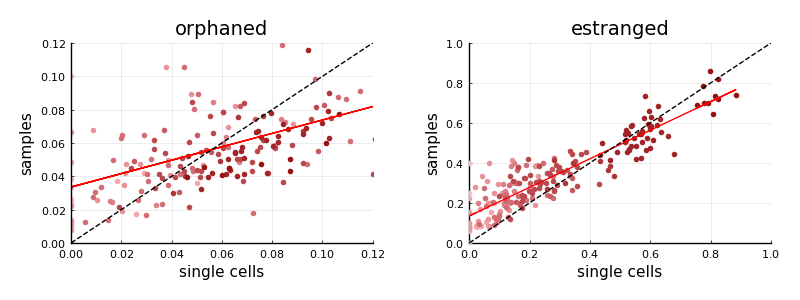

In [109]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], res.orphaned_sc, res.orphaned_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.12), ylims=(0,0.12), c=cgrad(:reds)[res.d], title="orphaned")
    
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique

    y = res.orphaned_sa
    w = hcat(ones(length(y)), res.orphaned_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], res.orphaned_sc, w * beta, c=:red)

    plot!(p[1], 0:0.12:0.12, x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], res.estranged_sc, res.estranged_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[res.d], title="estranged")
    
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique

    y = res.estranged_sa
    w = hcat(ones(length(y)), res.estranged_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], res.estranged_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

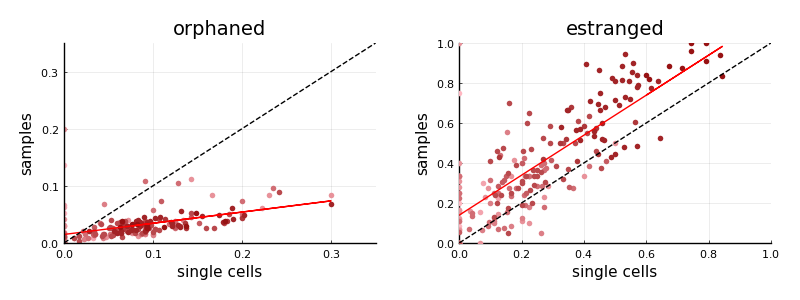

In [42]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], res.orphaned_sc, res.orphaned_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.35), ylims=(0,0.35), c=cgrad(:reds)[res.d], title="orphaned")
    
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique

    y = res.orphaned_sa
    w = hcat(ones(length(y)), res.orphaned_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], res.orphaned_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.35, length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], res.estranged_sc, res.estranged_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[res.d], title="estranged")
    
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique

    y = res.estranged_sa
    w = hcat(ones(length(y)), res.estranged_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], res.estranged_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

> N 80, res 1/600, 1/4

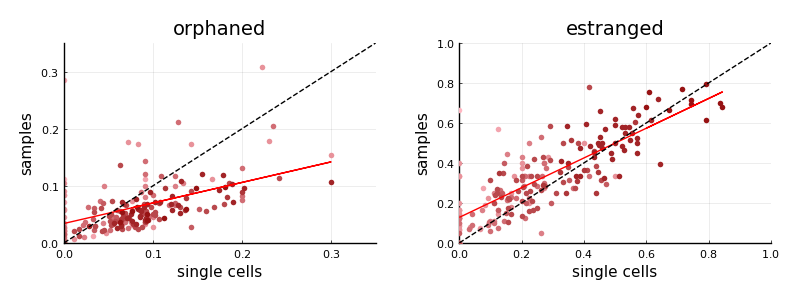

In [45]:
let mu = 0.2
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], res.orphaned_sc, res.orphaned_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.35), ylims=(0,0.35), c=cgrad(:reds)[res.d], title="orphaned")
    
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique

    y = res.orphaned_sa
    w = hcat(ones(length(y)), res.orphaned_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], res.orphaned_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.35, length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], res.estranged_sc, res.estranged_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[res.d], title="estranged")
    
    res = filter(row-> row.mu ≈ 0.2, turnover_data) |> unique

    y = res.estranged_sa
    w = hcat(ones(length(y)), res.estranged_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], res.estranged_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

> N 80, res 1/600, 1/3

In [7]:
drange = 0:0.1:0.9
ds = Float64[]
mus = Float64[]
Worph_sc = Vector{DataFrame}()
Westr_sc = Vector{DataFrame}()
Worph_sa = Vector{DataFrame}()
Westr_sa = Vector{DataFrame}()
mutcount = Int64[]
mutcount_post = Int64[]

# res = 1/200
Nthresh_orph = 50
samplecutoff_orph = 1/3
Nthresh_estr = 15
samplecutoff_estr = 1/3
mutnumb = 1000

let mu = 0.2
    paths = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in drange, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, d = parameters.b, parameters.d
        
        tumor = data_import(path)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
#         filter!.(m -> freqs[m] > res, tumor.mutations)
        subsampled_muts = unique(vcat(tumor.mutations...)) |> all_m -> sample(all_m, min(length(all_m),mutnumb), replace=false)
        filter!.(in(subsampled_muts), tumor.mutations)
        
        push!(mus, mu)
        push!(ds, d)
        push!(mutcount, length(subsampled_muts))
        
        #### single cell
        
        htypes = unique( tumor.mutations )
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, tumor.mutations) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), tumor.mutations) )
        
        
        W_l = orphaned_red_treeless(orphaned_tumor)
        W_o = estranged_treeless(estranged_tumor)
        
        push!(Worph_sc, W_l)
        push!(Westr_sc, W_o)
        
        #### sampling
        
        samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=30, cells_per_sample=20)
#         freqs = TumorGrowth.mutation_freqs(sampletumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        
        tumor = deepcopy(sampletumor)
        for row in eachrow(tumor)
            row.mutations = row.mutations[row.frequencies .>= samplecutoff_orph]
        end        
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh_orph, tumor.mutations) ) )
        
        tumor = deepcopy(sampletumor)
        for row in eachrow(tumor)
            row.mutations = row.mutations[row.frequencies .>= samplecutoff_estr]
        end
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh_estr for m in muts), tumor.mutations) )
        
        push!(mutcount_post, length(unique(vcat(tumor.mutations...))))
        
        W_l = orphaned_red_treeless(orphaned_tumor)
        W_o = estranged_treeless(estranged_tumor)
    
        
        push!(Worph_sa, W_l)
        push!(Westr_sa, W_o)
        
        next!(prog)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:14:32


In [12]:
# offspring_clade_fit, orphaned_clade_fit = [-17.652261535633116, 1.3496472290222599], [3.8407907093683753, 1.2014373638680613]
# offspring_clone_fit, estranged_clone_fit = [1.9828890232790028, 0.7950688448535779], [1.5051541766093208, 0.8536705669019635]

# n 285, Nthresh_orph 400, Nthresh_estr 400, res 1/10000, 1/3

# offspring_clade_fit, orphaned_clade_fit = [-3.1393344953000137, 0.3694065504550832], [0.28213233319606085, 0.9337963349045757]
# offspring_clone_fit, estranged_clone_fit = [2.0460394588109088, 0.27062540749285335], [1.742873794475777, 0.3815998563513362]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

# offspring_clade_fit, orphaned_clade_fit = [-6.430084645112598, 0.39525075684379357], [2.604014719408142, 0.6766215789072119]
# offspring_clone_fit, estranged_clone_fit = [0.6171384346016752, 0.4434068792265626], [1.1805686505598105, 0.6114024749558046]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3, mutnumb 75

# offspring_clade_fit, orphaned_clade_fit = [-12.265472456868345, 2.0721200281841874], [13.515351430887435, 1.95984197842931]
# offspring_clone_fit, estranged_clone_fit = [18.939600447524324, 2.521358909445503], [7.17261825141223, 3.306604792822085]

# n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, sangerlike-freqs (samplenumbers)

# offspring_clade_fit, orphaned_clade_fit = [6.477418192491858, 1.140429004503049], [0.016633669706656435, 0.9771120277921564]
# offspring_clone_fit, estranged_clone_fit = [0.7841582064297806, 1.0084602368866327], [0.10214122375441756, 0.9079758852470377]

# n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, mutnumb 35


offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / (sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / (sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

[NaN, NaN]
[NaN, NaN]


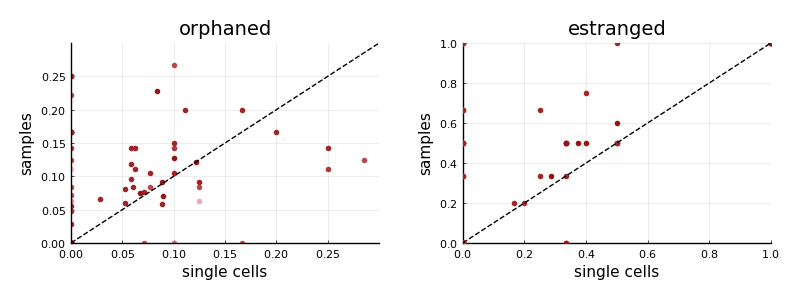

┌ Warning: Indices Base.OneTo(208) of attribute `seriescolor` does not match data indices 1:207.
└ @ Plots C:\Users\Arman Angaji\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Info: Data contains NaNs or missing values, and indices of `seriescolor` vector do not match data indices.
│ If you intend elements of `seriescolor` to apply to individual NaN-separated segements in the data,
│ pass each segment in a separate vector instead, and use a row vector for `seriescolor`. Legend entries
│ may be suppressed by passing an empty label.
│ For example,
│     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], seriescolor=[1 2])
└ @ Plots C:\Users\Arman Angaji\.julia\packages\Plots\FKcum\src\utils.jl:110
┌ Warning: Indices Base.OneTo(208) of attribute `linecolor` does not match data indices 1:207.
└ @ Plots C:\Users\Arman Angaji\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Info: Data contains NaNs or missing values, and indices of `linecolor` vector do not match data indices.
│ If you intend el

In [13]:
let
    t_o_sa = Worph_sa .|> correct_orph
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_e_sa = Westr_sa .|> correct_estr
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)/sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.3), ylims=(0,0.3), c=cgrad(:reds)[ds], title="orphaned")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    println(beta)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.3;length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[ds], title="estranged")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)
    beta = (w'*w) \ (w'*y)
    println(beta)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

[0.6717769480347783, 0.9789378991149869]
[0.08121122326141315, 0.8100955849821485]


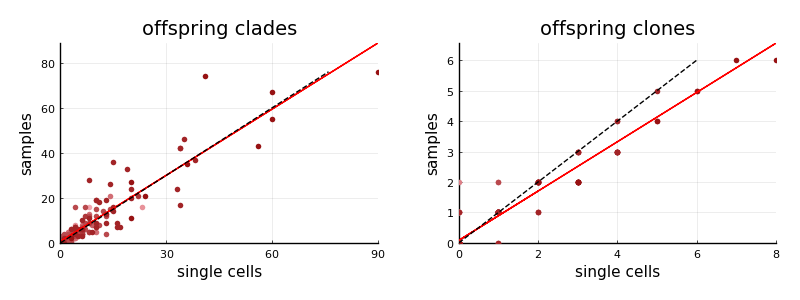

In [14]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isgreen)
    t_o_sa = Worph_sa .|> df -> sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="offspring clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)
    println(beta)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="offspring clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)
    println(beta)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

[0.2876255084528169, 1.262827876052379]
[0.0937361957770121, 0.9595370615778779]


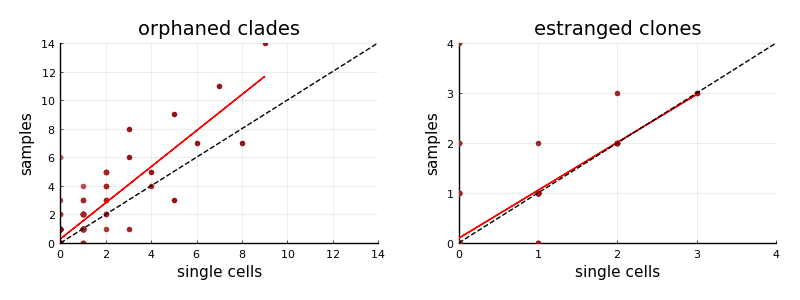

In [15]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="orphaned clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)
    println(beta)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="estranged clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)
    println(beta)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

> n 400, Nthresh 400, res 1/10000, 1/3

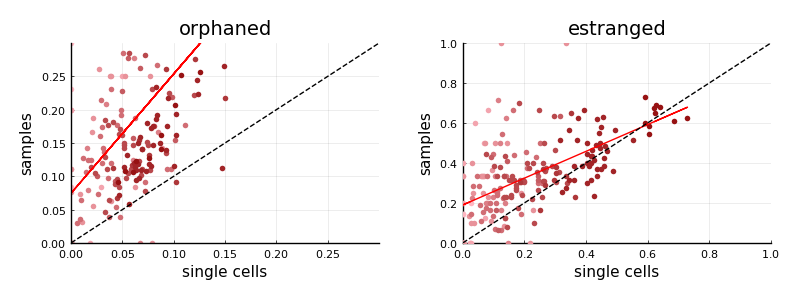

In [19]:
let
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)/sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)/sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.3), ylims=(0,0.3), c=cgrad(:reds)[ds], title="orphaned")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.3;length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[ds], title="estranged")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

clades [-33.893506575821554, 0.4349328435814411]
clones [-6.660477819336709, 0.4070617410934356]


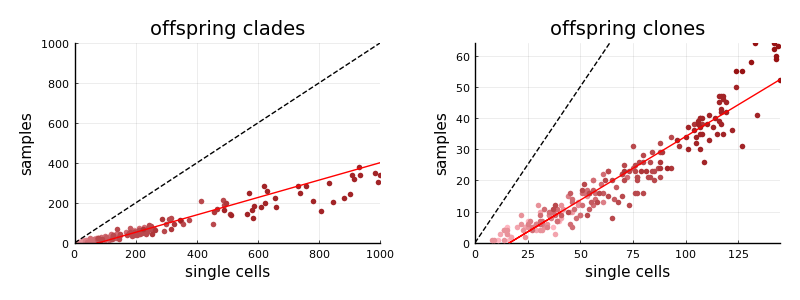

In [26]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isgreen)
    t_o_sa = Worph_sa .|> df -> sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,1000), ylims=(0,1000), c=cgrad(:reds)[ds], title="offspring clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)
    println("clades ",beta)
    
    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="offspring clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)
    println("clones ",beta)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

clades [-1.1384540609226408, 0.774298111507609]
clones [0.6587143683555302, 0.3804907188597655]


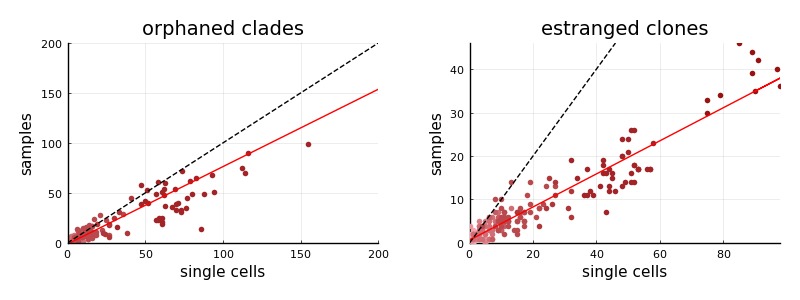

In [22]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)
    t_o_sa = Worph_sa .|> df -> orph_clades_x*sum(df.isorphaned)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)
    t_e_sa = Westr_sa .|> df -> estr_clones_x*sum(df.isestranged)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,200), ylims=(0,200), c=cgrad(:reds)[ds], title="orphaned clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)
    println("clades ",beta)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="estranged clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)
    println("clones ",beta)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

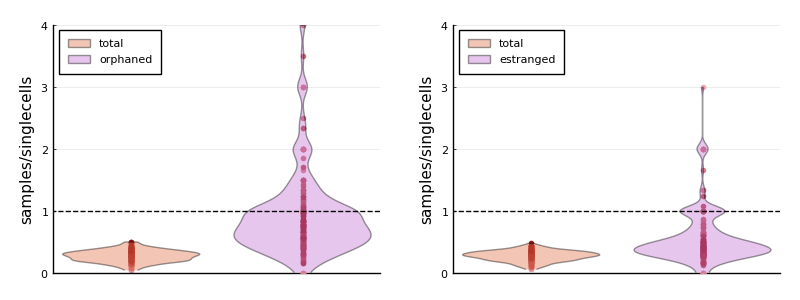

In [222]:
using StatsPlots
let
    
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:topleft, xlabel="", ylabel="samples/singlecells",xticks=:none)
    
    ###### orphaned
    
    t_o_sc = Worph_sc .|> df -> sum(df.isgreen)
    t_o_sa = Worph_sa .|> df -> sum(df.isgreen)
    t_o_sa ./= t_o_sc; t_o_sc .= 1
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., c=cgrad(:reds)[ds], title="", lab="", ylim=(0,4))
    violin!(p[1], [1], t_o_sa, alpha=0.4, lab="total")
    
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)
    wherezero = .!iszero.(t_o_sc)
    t_o_sa ./= t_o_sc; t_o_sc .= 2
    
    scatter!(p[1], t_o_sc[wherezero], t_o_sa[wherezero], alpha=1, markerstrokewidth=0., c=cgrad(:reds)[ds[wherezero]], lab="")
    violin!(p[1], [2], t_o_sa[wherezero], alpha=0.4, lab="orphaned")

    hline!(p[1], [1], c=:black, style=:dash, lab="")
    
    ##### estranged
    
    t_e_sc = Westr_sc .|> df -> sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isgreen)
    t_e_sa ./= t_e_sc; t_e_sc .= 1
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., c=cgrad(:reds)[ds], title="", ylim=(0,4), lab="")
    violin!(p[2], [1], t_e_sa, alpha=0.4, lab="total")
    
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)
    wherezero = .!iszero.(t_e_sc)
    t_e_sa ./= t_e_sc; t_e_sc .= 2
    
    scatter!(p[2], t_e_sc[wherezero], t_e_sa[wherezero], alpha=1, markerstrokewidth=0., c=cgrad(:reds)[ds[wherezero]], lab="")
    violin!(p[2], [2], t_e_sa[wherezero], alpha=0.4, lab="estranged")

    hline!(p[2], [1], c=:black, style=:dash, lab="")
end

> n 200, Nthresh 200, res 1/600, 1/2

[0.023758979438836186, 0.3088088168704815]
[0.164428317387124, 0.8823895443825707]


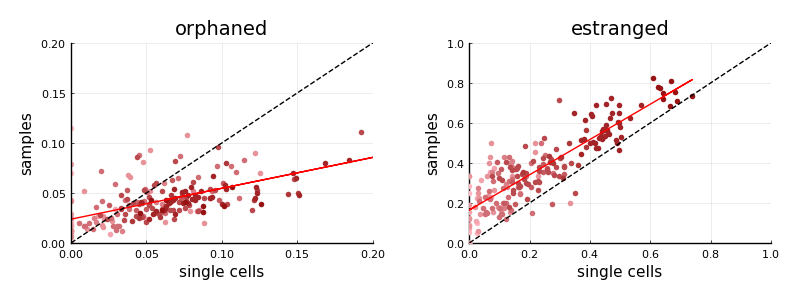

In [108]:
let
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)/sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)/sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.2), ylims=(0,0.2), c=cgrad(:reds)[ds], title="orphaned")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    println(beta)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.3;length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[ds], title="estranged")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    println(beta)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

In [ ]:
sa2sc_orphaned(tsa, p = [0.023, 0.308]) = (tsa-p[1])/p[2]
sa2sc_estranged(tsa, p = [0.164, 0.882]) = (tsa-p[1])/p[2]

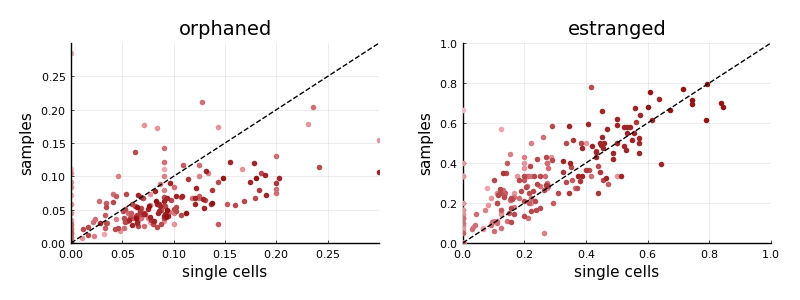

In [232]:
let
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)/sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)/sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.3), ylims=(0,0.3), c=cgrad(:reds)[ds], title="orphaned")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.3;length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[ds], title="estranged")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

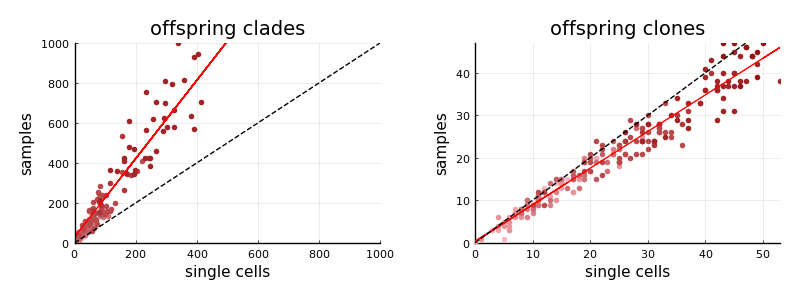

In [225]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isgreen)
    t_o_sa = Worph_sa .|> df -> sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,1000), ylims=(0,1000), c=cgrad(:reds)[ds], title="offspring clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="offspring clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

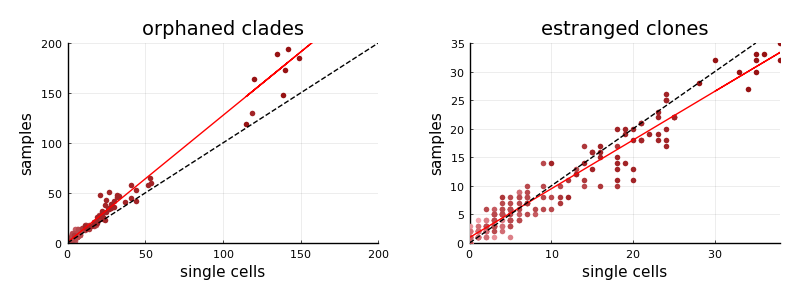

In [226]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,200), ylims=(0,200), c=cgrad(:reds)[ds], title="orphaned clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="estranged clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

> n 200, Nthresh 80, res 1/600, 1/3

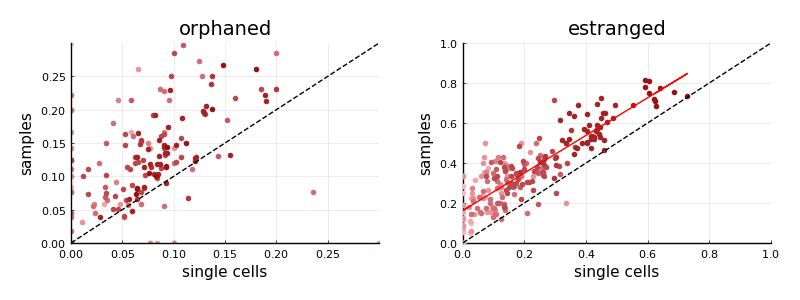

In [239]:
let
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)/sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)/sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.3), ylims=(0,0.3), c=cgrad(:reds)[ds], title="orphaned")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.3;length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[ds], title="estranged")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end

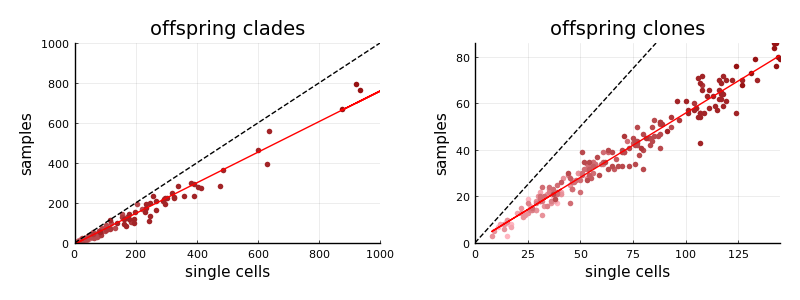

In [240]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isgreen)
    t_o_sa = Worph_sa .|> df -> sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,1000), ylims=(0,1000), c=cgrad(:reds)[ds], title="offspring clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="offspring clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

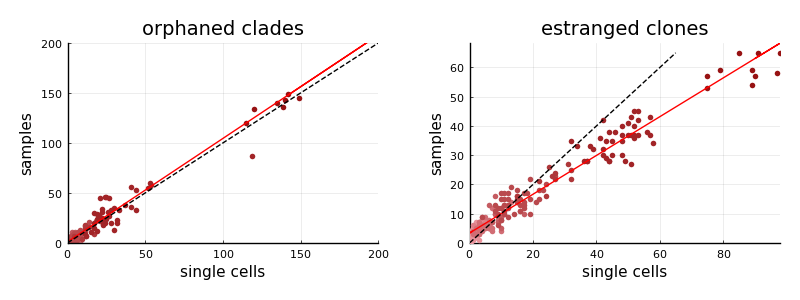

In [241]:
let
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,200), ylims=(0,200), c=cgrad(:reds)[ds], title="orphaned clades")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], 0:maximum(t_o_sa), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,:auto), ylims=(0,:auto), c=cgrad(:reds)[ds], title="estranged clones")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:maximum(t_e_sa), x->x, c=:black, style=:dash)
end

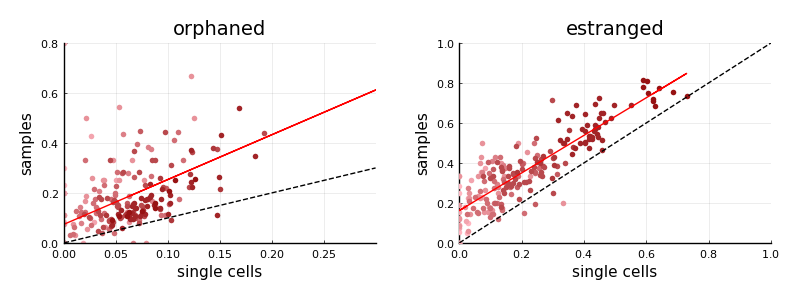

In [23]:
let
    t_o_sa = Worph_sa .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_o_sc = Worph_sc .|> df -> sum(df.isorphaned)/sum(df.isgreen)
    t_e_sa = Westr_sa .|> df -> sum(df.isestranged)/sum(df.isgreen)
    t_e_sc = Westr_sc .|> df -> sum(df.isestranged)/sum(df.isgreen)
    
    p = plot(layout=(1,2), size=(800,300), margin=5Plots.mm, legend=:none, xlabel="single cells", ylabel="samples")
    
    ###### orphaned
    
    scatter!(p[1], t_o_sc, t_o_sa, alpha=1, markerstrokewidth=0., xlims=(0,0.3), ylims=(0,0.8), c=cgrad(:reds)[ds], title="orphaned")

    y = t_o_sa
    w = hcat(ones(length(y)), t_o_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[1], t_o_sc, w * beta, c=:red)

    plot!(p[1], range(0,0.3;length=2), x->x, c=:black, style=:dash)
    
    ##### estranged
    
    scatter!(p[2], t_e_sc, t_e_sa, alpha=1, markerstrokewidth=0., xlims=(0,1), ylims=(0,1), c=cgrad(:reds)[ds], title="estranged")

    y = t_e_sa
    w = hcat(ones(length(y)), t_e_sc)

    beta = (w'*w) \ (w'*y)
    plot!(p[2], t_e_sc, w * beta, c=:red)

    plot!(p[2], 0:1, x->x, c=:black, style=:dash)
end